In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import os.path as osp
import xarray as xr
import sys
import os
import glob
import pickle5 as pickle
import yaml
import cartopy.crs as ccrs
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import cascaded_union
import imageio
from pvlib import solarposition

import utils

# Individual-Based Model Results
### Properties of simulated birds
 - initial position ($p_0$, randomly sampled from specified departure area)
 - date at which migration is initiated
 - preferred migration direction ($\alpha_{pref}$, sampled from wrapped Gaussian distribution with $mean=215^{\circ}$ and $std=5^{\circ}$)
 - air speed ($v_{air}=10 \ m/s$)
 - wind compensation $f_{wind}\in \left[0,1\right]$
 - tolerated energy expenditure per unit distance travelled along the preferred migration direction ($e_{tol}$ sampled from Gaussian distribution)
 - state (one of 'flying', 'landed', 'outside simulated area')

Air speed and wind compensation are the same for all simulated birds.

### Environmental variables
 - wind at $850mb$
 - sun position

### Dynamics
The trajectories of $N$ birds are simulated with a time resolution of 1 hour. <br>
At each time step, birds choose their next state based on their previous state and the environmental conditions at that time.

#### Departure
Birds decide to take off if all of the followind conditions are met:
 - it is the first hour after civil dusk (sun position $< -6^{\circ}$)
 - the bird has initiated its migration
 - the energy expenditure given the wind contitions, the bird's preferred direction and wind compensation is lower than the birds threshold $e_{tol}$
 - the wind conditions allow for the desired amount of compensation

Energy expenditure is computed as

$e = \frac{v_{air}}{v_{ground} * \cos(\gamma)} - 1$, with $\gamma$ the drift angle 

#### Flight behavior
For a flying bird the next position is computed as follows:

$p_{t+1} = p_{t} + \mathbf{v}_{ground}$,

with $\mathbf{v}_{ground}$ the ground speed vector with 
 - length $v_{ground} = v_{air} * \cos(\alpha_{head} - \gamma + v_{wind} * \cos(\beta - \gamma)$, <br> with $\alpha_{head}$ the bird's heading, $\beta$ the wind direction and $\gamma$ the drift angle, all given relative to the preferred direction of the bird $\alpha_{pref}$
 - direction $\alpha_{res} = \alpha_{pref} + \gamma$

The bird's heading and drift are computed as follows:
 - $\alpha_{head} = -\arcsin(\frac{f_{wind}*v_{wind}*\sin(\beta)}{v_{air}})$
 - $\gamma = \arctan(\frac{v_{air} * \sin(\alpha_{head}) + v_{wind} * \sin(\beta)}{v_{air} * \cos(\alpha_{head}) + v_{wind} * \cos(\beta)})$


### Load shape data

In [2]:
d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
departure_area = gpd.read_file(osp.join(d, 'departure_area.shp'))
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
sink = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi_sink.shp').to_crs(epsg='4326')
voronoi_with_sink = utils.add_sink_to_voronoi(voronoi, sink)
N = len(voronoi)

# crs for equal area transformation
crs_proj4 = ccrs.AlbersEqualArea().proj4_init

### Load Simulation Data

In [58]:
abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2015/experiment_2021-02-19 15:13:36.750872'
abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2016/experiment_2021-02-24 17:52:05.092618'
# abm_path = '/home/fiona/birdMigration/data/raw/abm/fall/2016'
# abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2018/experiment_2021-02-28 17:53:50.027289/'
# abm_path = '/home/fiona/birdMigration/data/raw/abm/fall/2016'
abm_path = '/home/fiona/birdMigration/data/raw/abm/fall/2015'
#abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2017/experiment_2021-03-26 12:50:21.974065/'
abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2017/experiment_2021-06-04 09:30:39.833676'
abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2016/experiment_2021-06-04 17:01:03.810564'
#traj, states, directions, speeds, time = utils.load_sim_results(abm_path)
traj = np.load(osp.join(abm_path, 'traj.npy'))
states = np.load(osp.join(abm_path, 'states.npy'))
directions = np.load(osp.join(abm_path, 'directions.npy'))
speeds = np.load(osp.join(abm_path, 'ground_speeds.npy'))
# with open(osp.join(abm_path, 'time.pkl'), 'rb') as f:
#     time = pickle.load(f)

# T = len(time)
with open(osp.join(abm_path, 'abm_config.yml')) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    
# simulation settings
print('Simulation Settings')
print('-'*40)
print(f'start date: {config["year"]}-{config["start_date"]}')
print(f'end date:   {config["year"]}-{config["end_date"]}')
print(f'number of birds: {config["num_birds"]}')
print(f'wind compensation: {config["settings"]["compensation"]*100}%')
print(f'tolerated energy expenditure: {config["settings"]["energy_tol_mean"]} +/- {config["settings"]["energy_tol_std"]}')

Simulation Settings
----------------------------------------
start date: 2016-08-01 12:00
end date:   2016-09-15 12:00
number of birds: 50
wind compensation: 100.0%
tolerated energy expenditure: 0.25 +/- 0.1


In [4]:
grid_counts = voronoi.to_crs('epsg:4326')
def get_points(trajectories, states, directions, speeds, state=1):
    df = gpd.GeoDataFrame({'geometry': [], 'direction': [], 'speed': []}, crs='epsg:4326')
    mask = np.where(states == state)
    if len(mask[0]) > 0:
        xx = trajectories[mask, 0].flatten()
        yy = trajectories[mask, 1].flatten()
        df['geometry'] = gpd.points_from_xy(xx, yy)
        df['direction'] = directions[mask].flatten()
        df['speed'] = speeds[mask].flatten()
    return df

merged = gpd.sjoin(get_points(traj[8], states[8], directions[8], speeds[8]), grid_counts, how='left', op='within')
merged[f'n_birds_t'] = 1
dissolve_counts = merged.dissolve(by="index_right", aggfunc="count")
dissolve_vals = merged.dissolve(by="index_right", aggfunc=np.nanmean)
name_t = 'n_birds_t'
grid_counts.loc[dissolve_counts.index, name_t] = dissolve_counts[name_t].values
grid_counts.loc[dissolve_vals.index, 'direction_t'] = dissolve_vals['direction'].values
grid_counts.loc[dissolve_vals.index, 'speed_t'] = dissolve_vals['speed'].values
grid_counts

,radar,x,y,x_eqa,y_eqa,lon,lat,boundary,geometry,n_birds_t,direction_t,speed_t
0,demem,100161.213331,-330545.407677,4.337444e+06,2.769967e+06,10.220420,48.043060,1,"POLYGON ((9.29495 46.85027, 9.10643 47.98666, ...",NaN,NaN,NaN
1,deisn,239812.932299,-311631.296412,4.477367e+06,2.786798e+06,12.101770,48.174700,1,"POLYGON ((11.34114 46.92995, 11.06864 48.68936...",NaN,NaN,NaN
2,deess,-132940.264869,44270.652352,4.110018e+06,3.148242e+06,6.966944,51.405556,0,"POLYGON ((5.63063 51.30777, 6.71487 52.37543, ...",NaN,NaN,NaN
3,depro,336845.421495,192326.623074,4.581966e+06,3.289091e+06,13.857810,52.648570,1,"POLYGON ((12.75334 51.90547, 12.18092 53.07667...",NaN,NaN,NaN
4,deoft,-11739.002630,-115366.625934,4.228765e+06,2.986753e+06,8.713970,49.985920,0,"POLYGON ((7.71313 50.62914, 7.79603 50.67043, ...",NaN,NaN,NaN
5,detur,66796.804848,-270746.671119,4.304968e+06,2.830232e+06,9.782780,48.585280,0,"POLYGON ((11.06864 48.68936, 9.10643 47.98666,...",NaN,NaN,NaN
6,deumd,157273.184072,128961.843315,4.401479e+06,3.228463e+06,11.176090,52.160090,0,"POLYGON ((10.07776 51.63380, 10.89515 53.14358...",NaN,NaN,NaN
7,bezav,-310903.581534,-3760.139838,3.931385e+06,3.103004e+06,4.455000,50.905499,1,"POLYGON ((3.15324 49.84687, 4.08818 51.67166, ...",NaN,NaN,NaN
8,deeis,255069.979215,-158844.116141,4.494901e+06,2.939271e+06,12.402780,49.540660,1,"POLYGON ((10.75523 49.45161, 12.63825 50.48735...",NaN,NaN,NaN
9,defbg,-65397.198004,-349908.652774,4.171609e+06,2.753124e+06,8.003860,47.873570,1,"POLYGON ((6.41106 48.70305, 6.56487 48.78579, ...",NaN,NaN,NaN


### Plot Example Trajectories

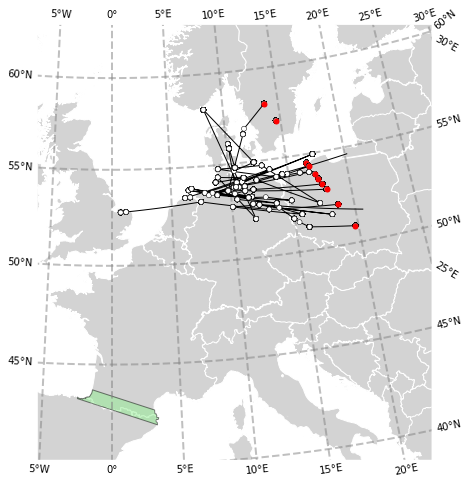

In [59]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw = {'projection' : gcrs.AlbersEqualArea()})
utils.plot_trajectories(ax, countries, target_area, traj, states, birds=range(10), extent=[-5.1, 40.16, 22.27, 61.60])
#ax.set_title('example trajectories', fontsize=20);

In [54]:
roi = countries[countries['ADMIN'].isin(['France', 'Spain', 'Andorra'])]
outer = cascaded_union(roi.geometry)
inner = gpd.GeoSeries(outer, crs='epsg:4326').to_crs('epsg:3035').buffer(-75_000).to_crs('epsg:4326')
inner2 = gpd.GeoSeries(outer, crs='epsg:4326').to_crs('epsg:3035').buffer(+75_000).to_crs('epsg:4326')
diff = outer.difference(inner.geometry[0])
diff2 = inner2.geometry[0].difference(outer)
# minx = -3
# maxx = 5
# miny = 40
# maxy_east = 42.8
# maxy_west = 44

minx = -2.5
maxx = 4
miny_east = 41.8
miny_west = 43.3
maxy_east = 42.5
maxy_west = 44

poly = Polygon([(minx, maxy_west), (maxx, maxy_east), (maxx, miny_east), (minx, miny_west)])
target_area = gpd.GeoSeries(diff.intersection(poly))
target_area = gpd.GeoSeries(diff2.intersection(poly))
target_area = gpd.GeoSeries(outer.intersection(poly))

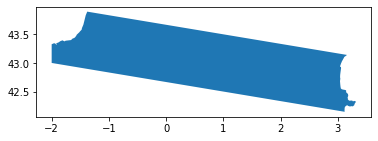

In [40]:
target_area.plot()

### Aggregate Trajectories into Bird Densities

In [5]:
# radar area counts [air]
radars = [Point(row.x, row.y).buffer(25_000) for i, row in voronoi.iterrows()]
radars = gpd.GeoDataFrame({'radar': voronoi['radar'], 'geometry': radars}, crs='epsg:3035')
radars = radars.to_crs(epsg='4326')

counts_rad, names_rad = utils.aggregate(traj, states, radars, range(T), state=1)
counts_rad = counts_rad.fillna(0)
rad_areas = radars.to_crs(crs_proj4).area

In [7]:
counts_rad

,radar,geometry,n_birds_0,n_birds_1,n_birds_2,n_birds_3,n_birds_4,n_birds_5,n_birds_6,n_birds_7,...,n_birds_1455,n_birds_1456,n_birds_1457,n_birds_1458,n_birds_1459,n_birds_1460,n_birds_1461,n_birds_1462,n_birds_1463,n_birds_1464
0,demem,"POLYGON ((-27.19259 10.70126, -27.18773 10.679...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,deisn,"POLYGON ((-26.06349 11.44067, -26.05869 11.418...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,deess,"POLYGON ((-30.11829 12.88578, -30.11254 12.864...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,depro,"POLYGON ((-26.52329 16.16636, -26.51762 16.145...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,deoft,"POLYGON ((-28.66994 12.07205, -28.66460 12.050...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,detur,"POLYGON ((-27.61755 11.07744, -27.61256 11.055...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,deumd,"POLYGON ((-27.88988 14.87512, -27.88418 14.853...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,bezav,"POLYGON ((-31.48033 11.66646, -31.47457 11.645...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,deeis,"POLYGON ((-26.30540 12.82538, -26.30034 12.803...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,defbg,"POLYGON ((-28.53136 9.82954, -28.52643 9.80791...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# voronoi cell counts [air]
counts_vor, names_vor = utils.aggregate(traj, states, voronoi, range(T), state=1)
counts_vor = counts_vor.fillna(0)
vor_areas = voronoi.to_crs(crs_proj4).area

In [24]:
# voronoi cell counts [ground]
counts_vor_gr, _ = utils.aggregate(traj, states, voronoi, range(T), state=0)
counts_vor_gr = counts_vor_gr.fillna(0)

#### Total Bird Counts per Hour

In [18]:
solarpos = [solarposition.get_solarposition(time, row.lat, row.lon).elevation for ridx, row in
                        voronoi.iterrows()]
solarpos = np.stack(solarpos, axis=0)
solarpos[solarpos >= -6] = np.nan 

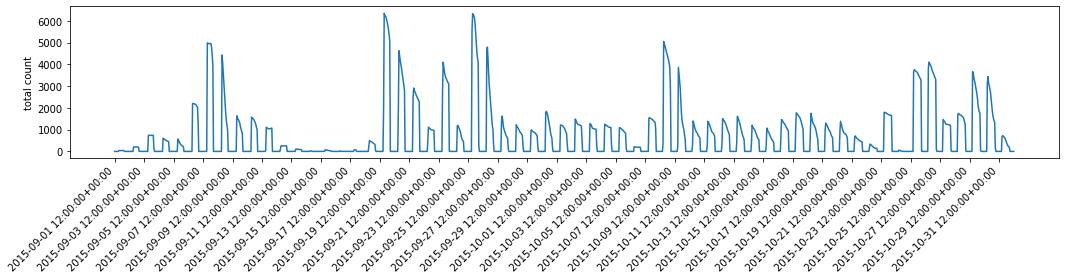

In [14]:
t_range = np.arange(T)
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(t_range, [counts_vor[f'n_birds_{t}'].sum() for t in t_range])
ax.set(ylabel='total count')
plt.xticks(t_range[::48], time[::48], rotation=45, ha='right');
fig.tight_layout()

#### Bird Counts per Voronoi Cell per Hour

mean deviation from true bird counts: 17.30272482857725 +/- 143.84415768627133


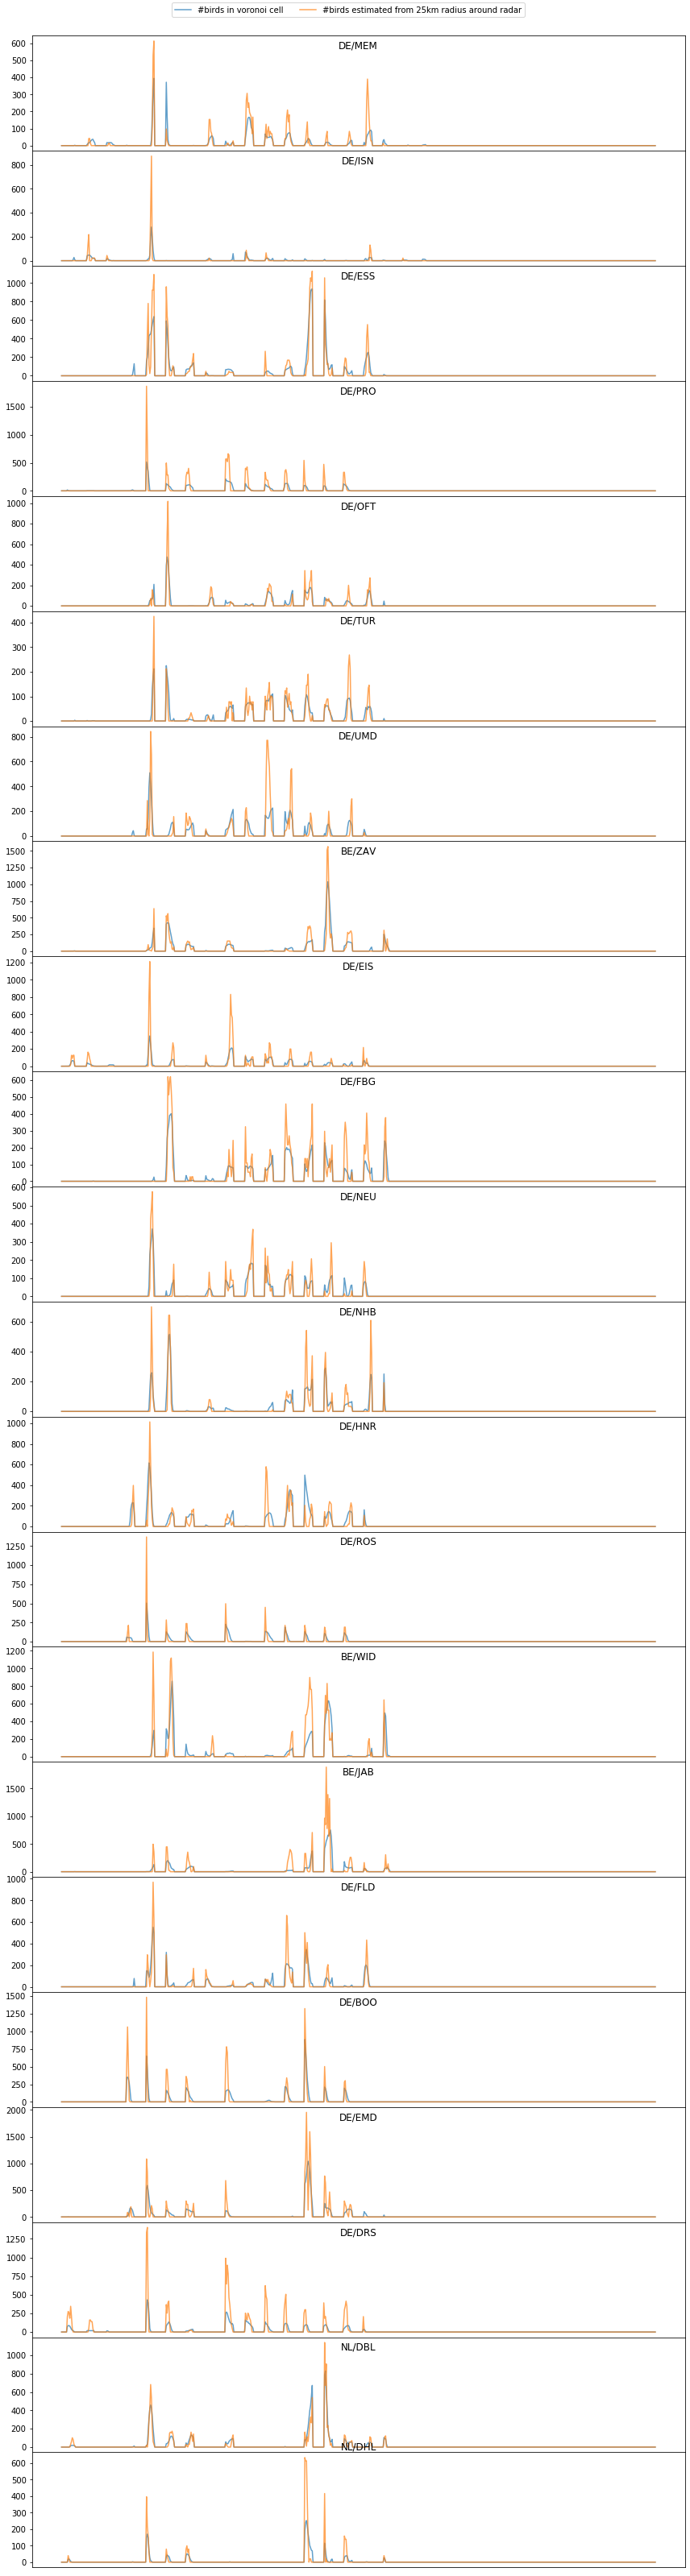

In [8]:
t_range = range(T)
n_radars = len(radars)
fig, ax = plt.subplots(n_radars, 1, figsize=(12,n_radars*2), sharex=True)
labels = ['#birds in voronoi cell', '#birds estimated from 25km radius around radar', 'sun position']
all_diff = []
for i in range(n_radars):
    vor = [counts_vor.iloc[i][f'n_birds_{t}'] for t in t_range]
    rad = [(counts_rad.iloc[i][f'n_birds_{t}'] / rad_areas.iloc[i]) * vor_areas.iloc[i] for t in t_range]
    
    idx = np.where(np.array(vor) > 0)
    all_diff.extend(np.array(rad)[idx]-np.array(vor)[idx])
    
    if i == n_radars-1:
        ax[i].plot(t_range, vor, alpha=0.7, label=labels[0])
        ax[i].plot(t_range, rad, alpha=0.7, label=labels[1])
        #ax[i].plot(t_range, solarpos[i], alpha=0.7, label=labels[2])
        ax[i].set_xticklabels(time)
    else:
        ax[i].plot(t_range, vor, alpha=0.7)
        ax[i].plot(t_range, rad, alpha=0.7)
        #ax[i].plot(t_range, solarpos[i], alpha=0.7)
        ax[i].set_xticks([])
    ax[i].set_title(counts_vor.iloc[i].radar, pad=-16)
    
fig.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.01))
fig.tight_layout()
fig.subplots_adjust(hspace=0)

print(f'mean deviation from true bird counts: {np.mean(all_diff):} +/- {np.std(all_diff)}')

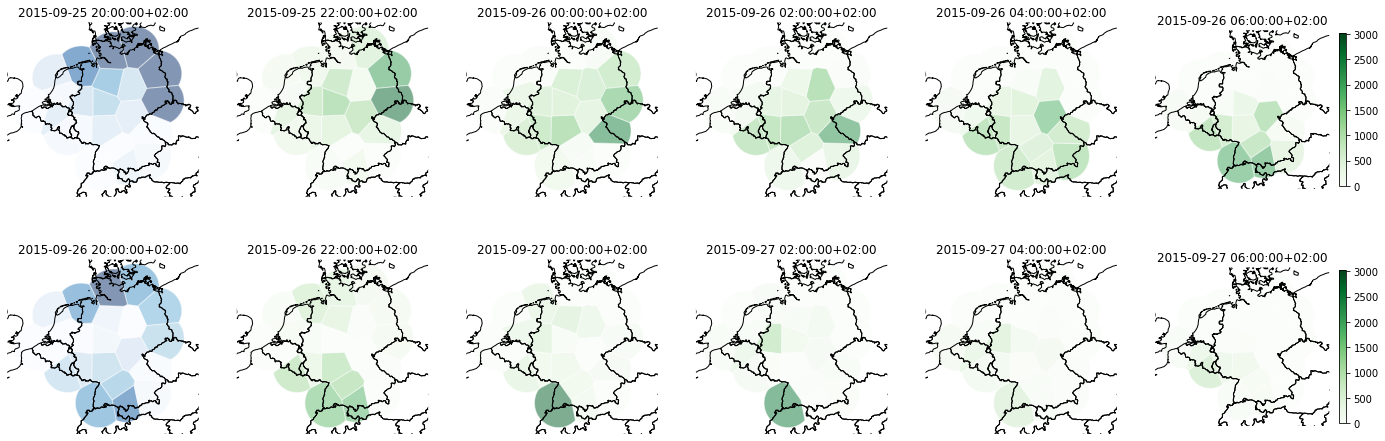

In [123]:
extent = [0.36, 46.36, 16.07, 55.40]
n_start = [128 + 19*24, 152 + 19*24]
num_t = 6

vmin = counts_vor[names_vor].min().min()
vmax = counts_vor[names_vor].max().max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap_gr = mpl.cm.ScalarMappable(norm=norm, cmap='Greens').cmap
cmap_bl = mpl.cm.ScalarMappable(norm=norm, cmap='Blues').cmap

fig, axes = plt.subplots(len(n_start), num_t, figsize=(num_t*4, 8), subplot_kw = {'projection' : gcrs.AlbersEqualArea()})
for i, start in enumerate(n_start):
    t_range = [start + dt*2 for dt in range(num_t)]
    for j, tidx in enumerate(t_range):
        legend=True if tidx == t_range[-1] else False
            
        axes[i,j].set_title(time[tidx])
        axes[i,j] = gplt.polyplot(countries, ax=axes[i,j], edgecolor="black", extent=extent, zorder=1)
        if j==0:
            q = counts_vor_gr
            cm = cmap_bl
        else:
            q = counts_vor
            cm = cmap_gr       
        gplt.choropleth(q, hue=names_vor[tidx], edgecolor='white', linewidth=1, ax=axes[i,j], alpha=0.5, zorder=0,
            cmap=cm, norm=norm, extent=extent, legend=legend, legend_kwargs={'fraction': 0.04} if legend else {});

### Determine Flows between Voronoi Cells

#### Theoretical estimate of max outflux per voronoi cell
Estimated maximal ground speed: $v_{ground}^{max}=20 \ m/s = 72 \ km/h$ <br>
A slightly more conservative estimate would be: $v_{ground}^{max}=15 \ m/s = 54 \ km/h$

This means that only birds located in the $v_{ground}^{max}$ margin from the voronoi cell boundary can move to adjacent cells.<br>
This gives the following estimates of the maximal relative outflux per cell:

In [79]:
voronoi_eqa = voronoi.to_crs(crs_proj4)
margin_72 = voronoi_eqa.difference(voronoi_eqa.buffer(-72_000))
margin_54 = voronoi_eqa.difference(voronoi_eqa.buffer(-54_000))
voronoi['max_outflux_72'] = margin_72.area / voronoi_eqa.area
voronoi['max_outflux_54'] = margin_54.area / voronoi_eqa.area
voronoi[['radar', 'max_outflux_72', 'max_outflux_54']]

,radar,max_outflux_72,max_outflux_54
0,DE/MEM,0.988261,0.880765
1,DE/ISN,0.900483,0.759123
2,DE/ESS,1.000000,0.931139
3,DE/PRO,0.870392,0.725225
4,DE/OFT,0.985318,0.878207
5,DE/TUR,1.000000,0.953318
6,DE/UMD,0.990266,0.879167
7,BE/ZAV,1.000000,0.979528
8,DE/EIS,0.963396,0.829686
9,DE/FBG,0.828701,0.681630


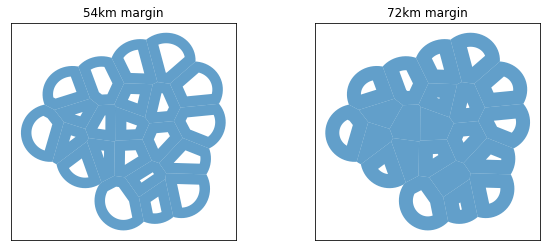

In [90]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
gpd.GeoSeries(margin_54, crs=crs_proj4).plot(ax=ax[0], alpha=0.7)
ax[0].set(xticks=[], yticks=[], title='54km margin')
gpd.GeoSeries(margin_72, crs=crs_proj4).plot(ax=ax[1], alpha=0.7)
ax[1].set(xticks=[], yticks=[], title='72km margin');

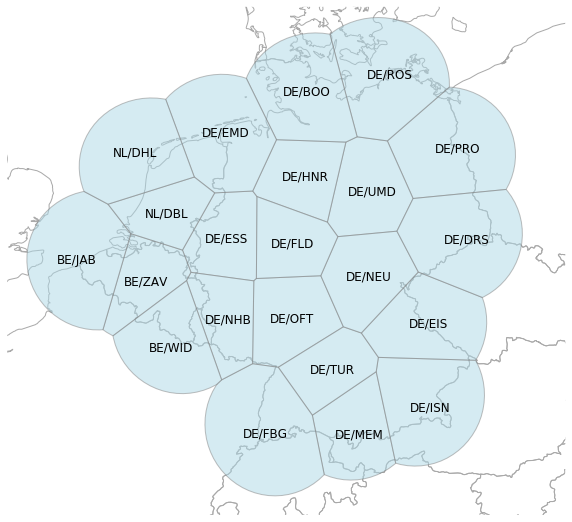

In [91]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw = {'projection' : gcrs.AlbersEqualArea()})
gplt.polyplot(countries, ax=ax, edgecolor="darkgray", extent=extent, zorder=1)
gplt.polyplot(voronoi, ax=ax, edgecolor="gray", facecolor='lightblue', alpha=0.5, extent=extent, zorder=2)

centroids = voronoi.to_crs(crs_proj4).centroid

for x, y, label in zip(centroids.geometry.x, centroids.geometry.y, voronoi.radar):
    ax.annotate(label, xy=(x, y), xytext=(-20, -5), textcoords="offset points", fontsize=12);

In [ ]:
tidx = 5
flows = utils.get_bird_flows(traj, states, tidx, voronoi_with_sink)

In [5]:
with open('/home/fiona/birdMigration/data/model_performance/abm_multiple_year_training/conservation=True_recurrent=True_embedding=0_timesteps=6/nights.pickle', 'rb') as f:
    nights = pickle.load(f)

In [11]:
outfluxes = np.zeros((N, N, T)) * np.nan
for nidx, night in enumerate(nights):
    for tidx in night:
        outfluxes[:,:,tidx] = np.load(osp.join(abm_path, 'outfluxes', f'{tidx}.npy'))[:N, :N]

In [12]:
for idx, radar in enumerate(voronoi.radar):
    print(f'outflux for radar {radar}')
    idx_fluxes = outfluxes[idx]
    mean_fluxes = np.nanmean(idx_fluxes, axis=-1)
    std_fluxes = np.nanstd(idx_fluxes, axis=-1)
    
    total = 0
    for jdx, flux in enumerate(mean_fluxes):
        if flux > 0:
            total += flux
            print(voronoi.radar.iloc[jdx], flux, '+/-', std_fluxes[jdx])
    print(f'total mean flux: {total} \n')

outflux for radar DE/MEM
DE/MEM 0.5197835261990311 +/- 0.40409431923419903
DE/TUR 0.000562429696287964 +/- 0.008945991968834006
DE/FBG 0.08944853260347711 +/- 0.17129223776912536
total mean flux: 0.6097944884987961 

outflux for radar DE/ISN
DE/MEM 0.1684708663722319 +/- 0.26429708184147715
DE/ISN 0.41958386057610314 +/- 0.41237722261524146
DE/TUR 0.009479879632679477 +/- 0.049257894908845856
total mean flux: 0.5975346065810145 

outflux for radar DE/ESS
DE/ESS 0.40111475199336 +/- 0.40816110864162336
DE/OFT 4.9118778723596416e-05 +/- 0.0004592509553737386
BE/ZAV 0.03187870258112248 +/- 0.06689535306828145
DE/NHB 0.10390398811226349 +/- 0.19946145167903342
DE/HNR 7.513373805373565e-06 +/- 0.00011950752630121766
BE/WID 0.013130085082977238 +/- 0.07286821261847864
DE/FLD 0.004422226135334132 +/- 0.027206219182208016
DE/EMD 8.168066128663377e-06 +/- 0.0001299210451905354
NL/DBL 0.01635158760856849 +/- 0.047744423316444504
total mean flux: 0.5708661417322834 

outflux for radar DE/PRO
DE/P

In [12]:
groups = flows.groupby('radar')
grouped = groups['dst_radar'].value_counts()



for src, dst in groups:
    print(f'outflux for radar {src}')
    z = dst['dst_radar'].value_counts().sum()
    print(dst['dst_radar'].value_counts() / z, '\n')

outflux for radar BE/JAB
BE/JAB    1.0
Name: dst_radar, dtype: float64 

outflux for radar BE/WID
BE/WID    0.548432
sink      0.449996
DE/FBG    0.001572
Name: dst_radar, dtype: float64 

outflux for radar BE/ZAV
BE/JAB    0.784823
BE/ZAV    0.203195
BE/WID    0.011982
Name: dst_radar, dtype: float64 

outflux for radar DE/BOO
DE/BOO    0.997614
DE/HNR    0.001472
DE/EMD    0.000914
Name: dst_radar, dtype: float64 

outflux for radar DE/DRS
DE/DRS    0.905820
DE/EIS    0.073015
DE/NEU    0.021165
Name: dst_radar, dtype: float64 

outflux for radar DE/EIS
DE/EIS    0.898371
DE/ISN    0.074851
DE/TUR    0.026778
Name: dst_radar, dtype: float64 

outflux for radar DE/EMD
DE/EMD    0.989411
DE/ESS    0.008390
NL/DBL    0.001702
DE/HNR    0.000497
Name: dst_radar, dtype: float64 

outflux for radar DE/ESS
DE/ESS    0.831187
DE/NHB    0.130618
BE/ZAV    0.024704
NL/DBL    0.008760
BE/WID    0.004731
Name: dst_radar, dtype: float64 

outflux for radar DE/FBG
DE/FBG    0.886264
sink      0.11

## TODO
 - compare model performance for abm data extracted from voronoi cells vs extracted from radar surroundings
 - compare estimated fluxes to true fluxes
 - try out departure model
 - compare to baseline models
     - random forest / gradient boosted trees / generalized additive model / ... (map environment to bird densities) [see van Doren & Horton (2018), Kranstauber (in progress)]
     - standard neural network / LSTM (no assumptions on spatial structure) --> compare amount of data needed to get similar accuracy